# Inspección de los datos y tratamiento de los valores faltantes.

El conjunto de datos Ripe y Rotten contiene datos sobre dos estados del mango. Este es un conjunto de datos multi-variables para determinar el estado de un mango a traves de una imagen.

El conjunto de datos contiene dos estados en los que se puede encontrar un mango que son: Ripe (Maduro) y Rotten (Podrido). Cada estado cuenta con una cantidad de ejemplos registrados. Rotten: 1492 imágenes y Ripe: 497 imágenes para un total de 1.989 ejemplos en el conjunto de datos. 


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from skimage.data import page
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

import warnings
import os
from PIL import Image
import skimage as ski

from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects

Cargando el conjunto de imagenes

In [44]:
path_ripe = "Ripe"
path_rotten = "Rotten"

data_images = []

def load_images_from_folder(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            data_images.append({'image_path': img_path, 'label': label})


load_images_from_folder(path_ripe, 'Ripe')
load_images_from_folder(path_rotten, 'Rotten')

print(f"{len(data_images)} Imágenes cargadas.")

1975 Imágenes cargadas.


A continuación se visualizarán el diagrama de clases y su distribución:

      image_path label
0     Ripe\1.jpg  Ripe
1    Ripe\10.jpg  Ripe
2  Ripe\1000.jpg  Ripe
3   Ripe\102.jpg  Ripe
4   Ripe\103.jpg  Ripe


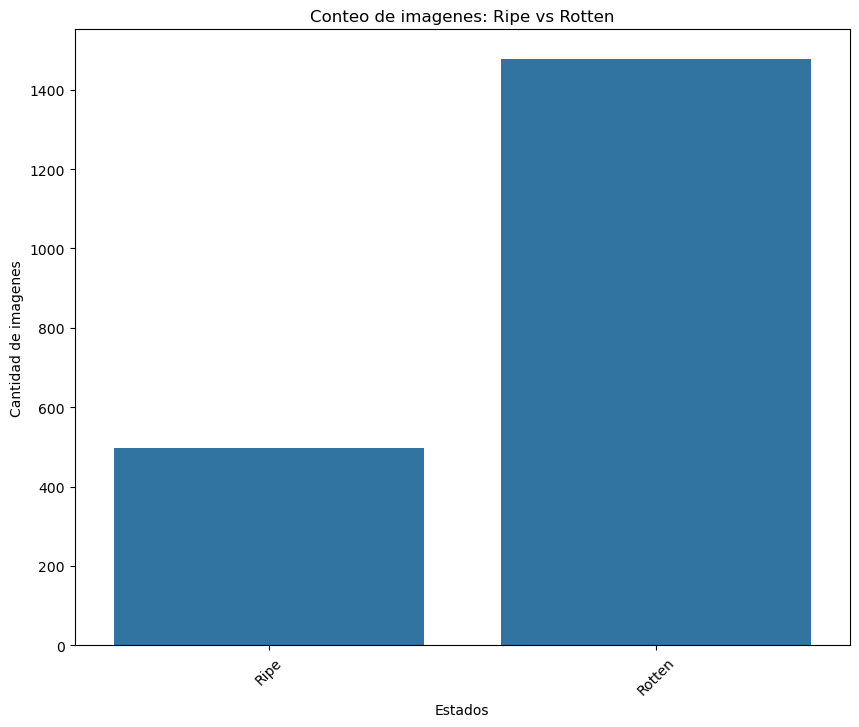

In [104]:
dataframe_images = pd.DataFrame(data_images)
print(dataframe_images.head())

if not dataframe_images.empty:
    plt.figure(figsize = (10,8))
    sns.countplot(x = 'label', data = dataframe_images)
    plt.title("Conteo de imagenes: Ripe vs Rotten")
    plt.xlabel("Estados")
    plt.ylabel("Cantidad de imagenes")
    plt.xticks(rotation = 45)
    plt.show()
else:
    print("No hay imagenes para mostrar en el histograma.")

A continuación se usan las funciones convert_toGrayImage, get_binaryMango, std_image, extract properties para extraer las propiedades del mango o variables predictoras del estado.

In [106]:
def convert_toGrayImage(filename):
    img = ski.io.imread(filename)
    img = ski.util.img_as_ubyte(img)
    gray_image = rgb2gray(img)
    return gray_image, img

In [107]:
def get_binaryMango(gray_image, sigma=1.0, connectivity = 2):
    blurred_image = ski.filters.gaussian(gray_image, sigma=sigma)
    bin_image = blurred_image > threshold_otsu(blurred_image)
    
    filled_img = binary_fill_holes(bin_image)
    labeled_image, count = ski.measure.label(filled_img, connectivity=connectivity, return_num=True)

    object_features = ski.measure.regionprops(labeled_image)
    object_areas = [objf["area"] for objf in object_features]
    max_size = max(object_areas)

    mango_mask = remove_small_objects(labeled_image, min_size=max_size-1)
    #plt.imshow(mango_mask)
    #plt.show() 

    mango_mask = mango_mask < 1
    return mango_mask

In [65]:
def std_image(gray_img, mango_mask):
    mango_mask = ski.util.invert(mango_mask)
    idx_list = np.where(mango_mask == 1)
    mangoPixel_values = gray_img[idx_list]
    stdev = statistics.stdev(mangoPixel_values)
    return stdev

In [116]:
import statistics
    
def extract_properties(mango_img, gray_img, mango_mask):

    labeled_mango, count = ski.measure.label(mango_mask, connectivity=2, return_num=True)
    object_features = ski.measure.regionprops(labeled_mango)

    var_color_props = ['intensity_mean']
    color_props = ski.measure.regionprops_table(labeled_mango, mango_img, properties=var_color_props)

    var_gris_props = ['area', 'intensity_max', 'intensity_min', 'intensity_mean']
    gris_props = ski.measure.regionprops_table(labeled_mango, gray_img, properties=var_gris_props)
    
    grayImg_stdev = std_image(gray_img, mango_mask)
    df_image = pd.DataFrame(gris_props)
    
    df_image.rename(columns={'intensity_max': 'max_gray_value', 'intensity_min': 'min_gray_value', 'intensity_mean': 'mean_gray_value'}, inplace=True)
    
    df_image['mean_value_R'] = color_props['intensity_mean-0'] 
    df_image['mean_value_G'] = color_props['intensity_mean-1'] 
    df_image['mean_value_B'] = color_props['intensity_mean-2']
    df_image['std'] = grayImg_stdev 
    
    print(df_image.head())

In [110]:
def intensity_table(grayValues):
    table = {}
    for ival in range(256):
        table['val_'+ str(ival)] = [np.count_nonzero(grayValues == ival)]
       
    df_table = pd.DataFrame.from_dict(table, orient='columns')
    return df_table

In [112]:
def hist2features(grayImg, mangoMask):
    #color = ski.util.img_as_ubyte(colorImg)
    gray = ski.util.img_as_ubyte(grayImg)
    mango_mask = ski.util.invert(mangoMask)

    masked_gray = gray * mango_mask
    plt.imshow(masked_gray, cmap = 'gray')
    plt.show()
    df_intensities = intensity_table(masked_gray)
    print(df_intensities)
    return df_intensities

A continuación, se crea una lista que va a almacenar las caracteristicas de las imagenes y se crea un bucle que procesa todas las imagenes del dataframe que contiene en este punto sólo las imagenes cargadas(dataframe_images). Luego, esta lista se convierte en dataframe para que puedan ser visualizadas las caracteristicas extraídas.

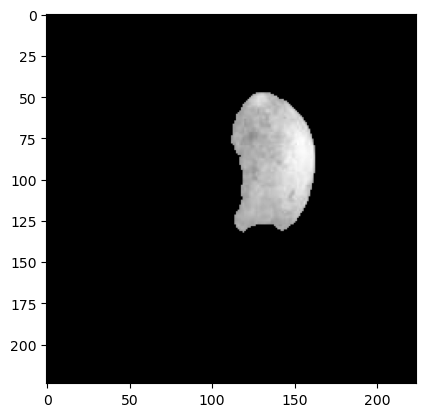

   val_0  val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  ...  \
0  46869      0      0      0      0      0      0      0      0      0  ...   

   val_246  val_247  val_248  val_249  val_250  val_251  val_252  val_253  \
0        0        0        0        0        0        0        0        0   

   val_254  val_255  
0        0        0  

[1 rows x 256 columns]
      area  max_gray_value  min_gray_value  mean_gray_value  mean_value_R  \
0  46869.0             1.0        0.096415         0.249934     64.037808   

   mean_value_G  mean_value_B       std  
0     63.635388       63.8039  0.063845  


TypeError: 'NoneType' object does not support item assignment

In [118]:
data_images_features = []

for _, row in dataframe_images.iterrows():
    img_path = row['image_path']
    label = row['label']
    
    gray_image, mango_img = convert_toGrayImage(img_path)
    
    mango_mask = get_binaryMango(gray_image)

    hist2features(gray_image, mango_mask)
    
    mango_features = extract_properties(mango_img, gray_image, mango_mask)
    
    mango_features['label'] = label

    data_images_features.append(mango_features)

df_mango_features = pd.concat(data_images_features, ignore_index=True)

print(df_mango_features.head())
